<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Кощегулов Эльдар, allincool@mail.ru

## <center> Индивидуальный проект по анализу данных </center>
## <center> Классификация спама в SMS </center>

###  Описание набора данных и признаков

#### Цель работы. 
Задача состоит в том, чтобы построить модель классификации спам сообщений в SMS, на основе имеющихся данных.
#### Входные данные.
Решаться задача будет на датасете взятом тут: https://www.kaggle.com/uciml/sms-spam-collection-dataset

* v1 метка spam/ham
* v2 текст sms

Целевой признак является метка spam/ham является ли SMS спамом или нет

###  Первичный анализ 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [3]:
df = pd.read_csv('../../data/spam.csv', encoding='latin-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


#### В заявленных признаках v1 и v2 пропущенных значений нет. Видим что помимо признаков v1 и v2 имеем еще 3 признака. Скорее всего это какой-то мусор

In [6]:
df['Unnamed: 2'].unique()[: 5]

array([nan, ' PO Box 5249',
       ' the person is definitely special for u..... But if the person is so special',
       ' HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\\""',
       ' wanted to say hi. HI!!!\\" Stop? Send STOP to 62468"'],
      dtype=object)

In [7]:
df[df['Unnamed: 2'] ==  ' PO Box 5249']

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN


#### Добавим данные из трех "левых" столбцов к тесту SMS и удалим их. Переименуем признаки. Для удобства переобозначим метки
* spam - 1
* ham - 0

In [8]:
df['v2'] = df['v2'] + df['Unnamed: 2'].fillna('') + df['Unnamed: 3'].fillna('') + df['Unnamed: 4'].fillna('')

In [9]:
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [10]:
df.rename(columns = {'v1' : 'label', 'v2' : 'sms'}, inplace = True)

In [11]:
df['label'] = df['label'].map({'spam' : 1, 'ham' : 0})

In [12]:
df.head()

,label,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Датасет содержит 5572 объекта. Теперь пропущенных значений в нем нет.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null int64
sms      5572 non-null object
dtypes: int64(1), object(1)
memory usage: 87.1+ KB


#### Посмотрим как выглядит обычное SMS и спам SMS

In [14]:
df[df['label'] == 0].sample(3)

,label,sms
1227,0,So Ì_'ll be submitting da project tmr rite?
1581,0,Hhahhaahahah rofl wtf nig was leonardo in your...
441,0,You were supposed to wake ME up &gt;:(


In [15]:
df[df['label'] == 1].sample(3)

,label,sms
1365,1,HOT LIVE FANTASIES call now 08707509020 Just 2...
855,1,Talk sexy!! Make new friends or fall in love i...
877,1,Sunshine Quiz Wkly Q! Win a top Sony DVD playe...


#### В спам-сообщениях часто много заглавных букв, восклицательных знаков, и чисел, типа поздравляем вы выиграли миллион

#### Посмотрим на распределение классов.

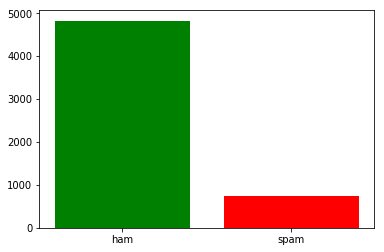

In [16]:
_, ax = plt.subplots()
plt.bar(np.arange(2), df['label'].value_counts(), color = ['green', 'red'])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['ham', 'spam']);

In [17]:
df['label'].value_counts()[1] / df.shape[0], df['label'].value_counts()[0] / df.shape[0]

(0.13406317300789664, 0.8659368269921034)

#### Видим что классы несбалансированы

### Инсайты

#### Здравый смысл подсказывает, что обычно в спам сообщениях вам пишут какие-то левые люди, которые представляются вашими друзьями и зовут куда-то зарегистрироваться или вас поздравляют с выигрышами в лотерею. Значит признаки большого количества заглавных букв, обилия знаков препинания и чисел в текстах сообщений, должны что-то дать

### Генерация признаков

#### Пока что будем генерировать признаки для объединенной выборки. Удалим знаки препинания, удалим опечатки, приведем тексты к нижнему регистру, сгенерируем признаки длина текста, число знаков препинания, наличие символа, не являющегося цифрой или буквой алфавита.

#### Первым признаком который мы создадим будет длина SMS. Обычно SMS имеют ограничения на количество слов, поэтому спамеры чтобы не платить много денежек стараются не превосходить эту длину

In [18]:
df['len'] = df['sms'].apply(lambda x : len(x.strip().split()))

#### Создадим счетчик знаков препинания в тексте SMS, а затем удалим знаки препинания. В идеале нужен счетчик восклицательных знаков, так как в спаме вас обычно поздравляют с выигрышами в лотереях и прочем и используют много восклицаний

In [19]:
import regex as re    

In [20]:
df['punctuation'] = df['sms'].apply(lambda x : len(re.findall("[^\P{P}-]+", x)))
df['punctuation'] = df['sms'].apply(lambda x : len(re.findall("[^\P{P}-]+", x)))

In [21]:
df['sms'] = df['sms'].apply(lambda x : re.sub("[^\P{P}-]+", "", x))

#### Создадим счетчик заглавных букв в тексте SMS, а затем приведем тексты к нижнему регистру.. Зачастую в спам сообщениях пишут капсом.

In [22]:
df['capital'] = df['sms'].apply(lambda x : sum(1 for c in x if c.isupper()))

In [23]:
df['sms'] = df['sms'].apply(lambda x : str.lower(x))

#### Посмотрим какие символы встречаются в текстах. Видим что помимо букв и цифр еще встречается много мусора. Создадим бинарный признак: содержит ли текст SMS символ кроме буквы и цифры. 

In [24]:
symbols = {}
for x in [item for sublist in list(map(list, df['sms'].tolist())) for item in sublist] :
    if x in symbols :
        symbols[x] += 1
    else :
        symbols[x] = 1
symbols

{'\r': 2,
 ' ': 81955,
 '$': 23,
 '+': 137,
 '-': 585,
 '0': 3189,
 '1': 1751,
 '2': 1719,
 '3': 852,
 '4': 1057,
 '5': 1073,
 '6': 806,
 '7': 858,
 '8': 1315,
 '9': 665,
 '<': 6,
 '=': 47,
 '>': 31,
 '^': 1,
 'a': 25371,
 'b': 5354,
 'c': 8914,
 'd': 11374,
 'e': 35158,
 'f': 5785,
 'g': 8350,
 'h': 14302,
 'i': 22577,
 'j': 948,
 'k': 4560,
 'l': 15853,
 'm': 10634,
 'n': 21897,
 'o': 29150,
 'p': 6867,
 'q': 236,
 'r': 17831,
 's': 19005,
 't': 28106,
 'u': 12399,
 'v': 3542,
 'w': 8520,
 'x': 1617,
 'y': 10450,
 'z': 505,
 '|': 36,
 '~': 3,
 '\x89': 69,
 '\x8b': 1,
 '\x8e': 1,
 '£': 329,
 '©': 3,
 'ª': 3,
 '¬': 2,
 '´': 1,
 '¼': 1,
 'á': 2,
 'â': 1,
 'ä': 1,
 'å': 382,
 'è': 1,
 'ì': 180,
 'ï': 55,
 'ð': 3,
 'ò': 11,
 'ó': 6,
 'ô': 2,
 'õ': 39,
 'ö': 1,
 '÷': 37,
 'û': 69}

In [25]:
volwes = 'aeiou'
consonant = 'bcdfghjklmnpqrstvwxyz'
digits = '0123456789'
alphabet = set(volwes) | set(consonant) | set(digits)

In [26]:
len(alphabet)

36

In [27]:
bad_symbols = [x for x in symbols if x not in alphabet]
bad_symbols = ''.join(set(bad_symbols) - set(' '))
bad_symbols

'û÷óô|\x8b>~ð¬=ò\x89è£á$å´ïâª<ö©\r¼^+õ-\x8eäì'

In [28]:
df['badsymbol'] = df['sms'].apply(lambda x :1 if len([s for s in x if s in bad_symbols]) > 0 else 0)

#### Попробуем исправить опечатки

In [29]:
df['sms'] = df['sms'].str.replace('å', 'a').str.replace('ä', 'a').str.replace('â', 'a').str.replace('á', 'a')
df['sms'] = df['sms'].str.replace('õ', 'o').str.replace('ò', 'o').str.replace('ð', 'o').str.replace('ö', '0') \
                    .str.replace('ó', 'o').str.replace('ô', 'o')
df['sms'] = df['sms'].str.replace('û', 'u')
df['sms'] = df['sms'].str.replace('è', 'e')
df['sms'] = df['sms'].str.replace('ì', '1').str.replace('ï', 'l')

#### В спам сообщениях часто упоминаются крупные денежные выигрыши. Нужно создать признаки : наличие числа в тексте и наличие символа валюты

#### Замечаем что среди символов в текстах имеются '$' и '£'. Создадим признак для них.

In [30]:
df['moneysign'] = df['sms'].apply(lambda x : 1 if ('$' in list(x)) or ('£' in list(x)) else 0 )

####  Остальные символы поудаляем. Вообще, возможно что при удалении знаков препинания мы поудаляли смайлы и возможно наличие/отсутствие смайла будет хорошим признаком. Если будет время надо подумать над этим. Признак исправлял ли я или нет

In [31]:
symbols = {}
for x in [item for sublist in list(map(list, df['sms'].tolist())) for item in sublist] :
    if x in symbols :
        symbols[x] += 1
    else :
        symbols[x] = 1

In [32]:
bad_symbols = [x for x in symbols if x not in alphabet]
bad_symbols = ''.join(set(bad_symbols) - set(' '))
bad_symbols

'÷|\x8bª>~<©¬=\r\x89¼^£+-$\x8e´'

In [33]:
for symb in bad_symbols : 
    df['sms'] = df['sms'].str.replace(symb, '')

In [34]:
symbols = {}
for x in [item for sublist in list(map(list, df['sms'].tolist())) for item in sublist] :
    if x in symbols :
        symbols[x] += 1
    else :
        symbols[x] = 1
symbols

{' ': 81955,
 '0': 3190,
 '1': 1931,
 '2': 1719,
 '3': 852,
 '4': 1057,
 '5': 1073,
 '6': 806,
 '7': 858,
 '8': 1315,
 '9': 665,
 'a': 25757,
 'b': 5354,
 'c': 8914,
 'd': 11374,
 'e': 35159,
 'f': 5785,
 'g': 8350,
 'h': 14302,
 'i': 22577,
 'j': 948,
 'k': 4560,
 'l': 15908,
 'm': 10634,
 'n': 21897,
 'o': 29211,
 'p': 6867,
 'q': 236,
 'r': 17831,
 's': 19005,
 't': 28106,
 'u': 12468,
 'v': 3542,
 'w': 8520,
 'x': 1617,
 'y': 10450,
 'z': 505}

In [35]:
df.head()

,label,sms,len,punctuation,capital,badsymbol,moneysign
0,0,go until jurong point crazy available only in ...,20,4,3,0,0
1,0,ok lar joking wif u oni,6,2,2,0,0
2,1,free entry in 2 a wkly comp to win fa cup fina...,28,6,10,0,0
3,0,u dun say so early hor u c already then say,11,2,2,0,0
4,0,nah i dont think he goes to usf he lives aroun...,13,2,2,0,0


#### Создадим признак: наличие в тексте SMS числа(возможно надо проверять не просто число, а число с множествой нулей).

In [36]:
df['num'] = df['sms'].apply(lambda x : 1 if len([s for s in x if s in digits]) > 0 else 0)

In [37]:
df.columns

Index(['label', 'sms', 'len', 'punctuation', 'capital', 'badsymbol',
       'moneysign', 'num'],
      dtype='object')

#### Полезность признаков будем исследовать в дальнейшем с помощью модели

#### Разобьем данные на трейн и тест с одинаковым распределением целевой переменной

In [38]:
target = df['label'].values

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, stratify = target, random_state = 10)

In [40]:
y_train.sum() / len(y_train), y_test.sum() / len(y_test)

(0.13417096701817366, 0.1336322869955157)

In [41]:
X_train.shape, X_test.shape

((4457, 8), (1115, 8))

#### В трейне 4457 объектов, в тесте 1115

### Визуальный анализ

#### Построим гистограммы созданных признаков слева и гистограммы созданных признаков в зависимости от целевой переменной справа

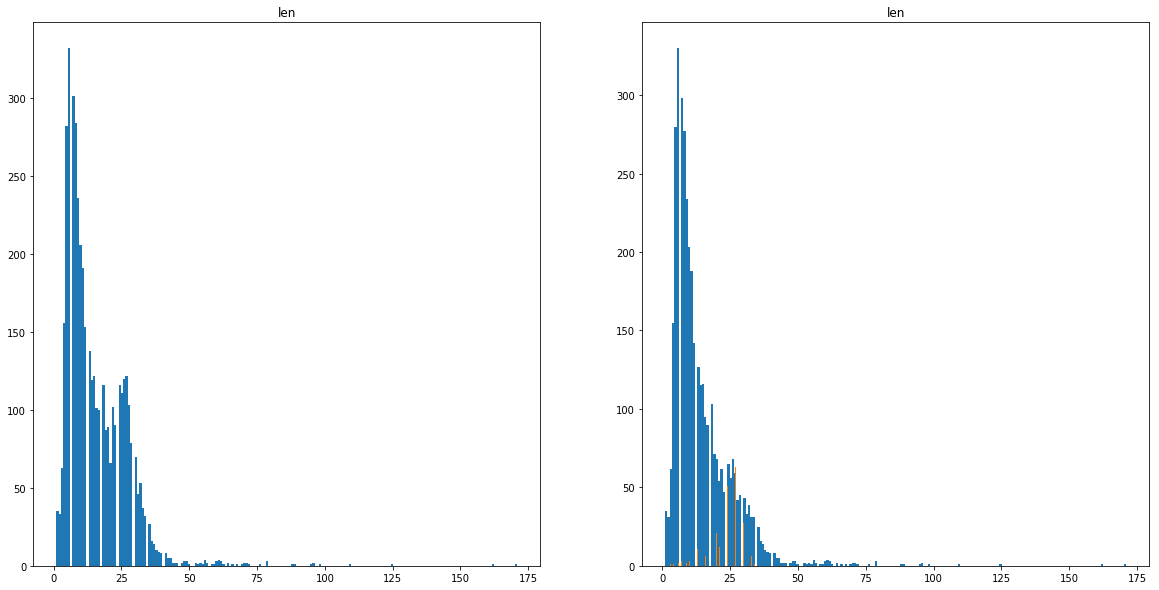

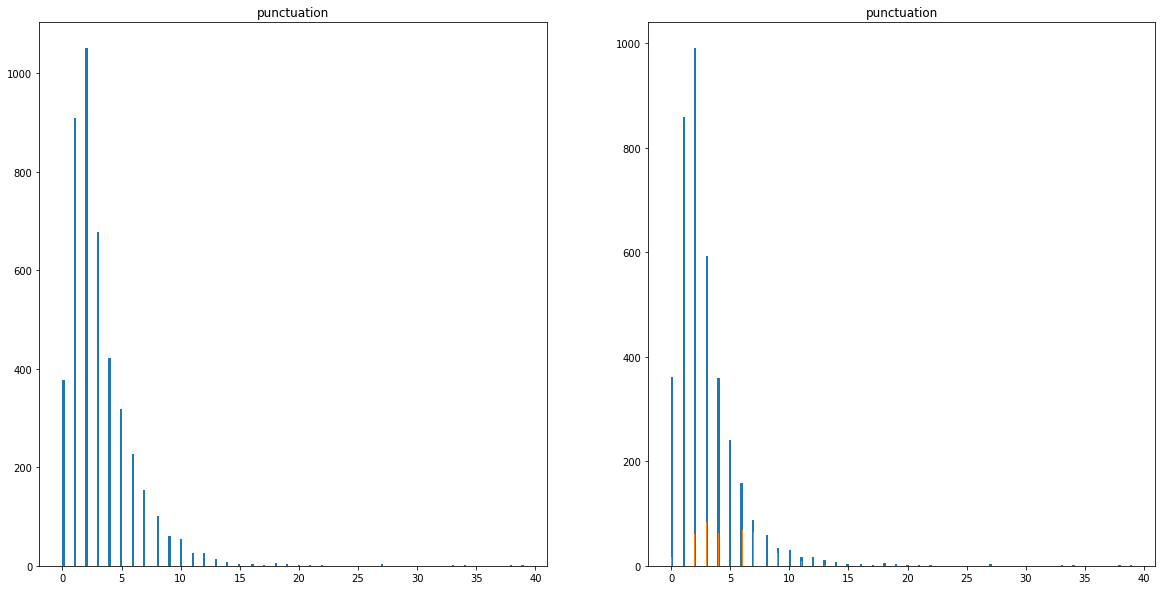

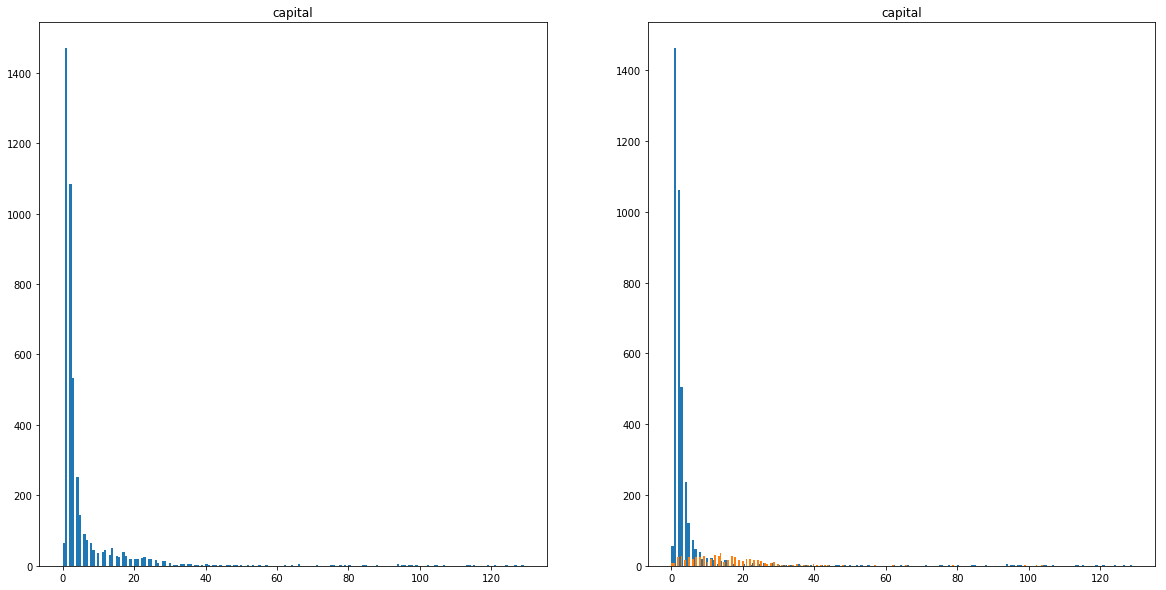

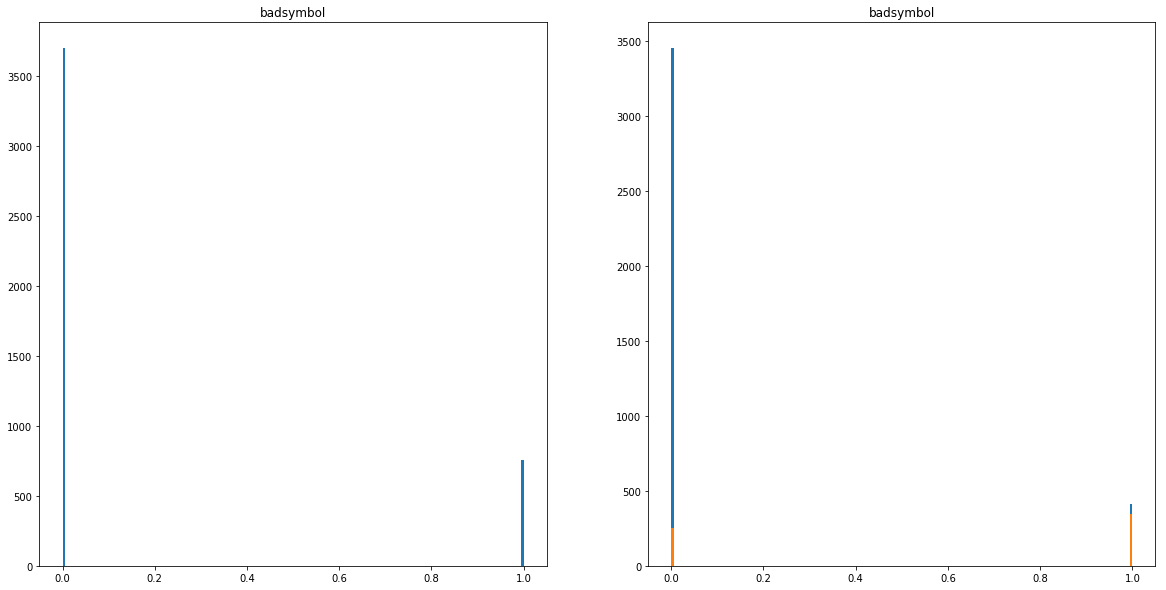

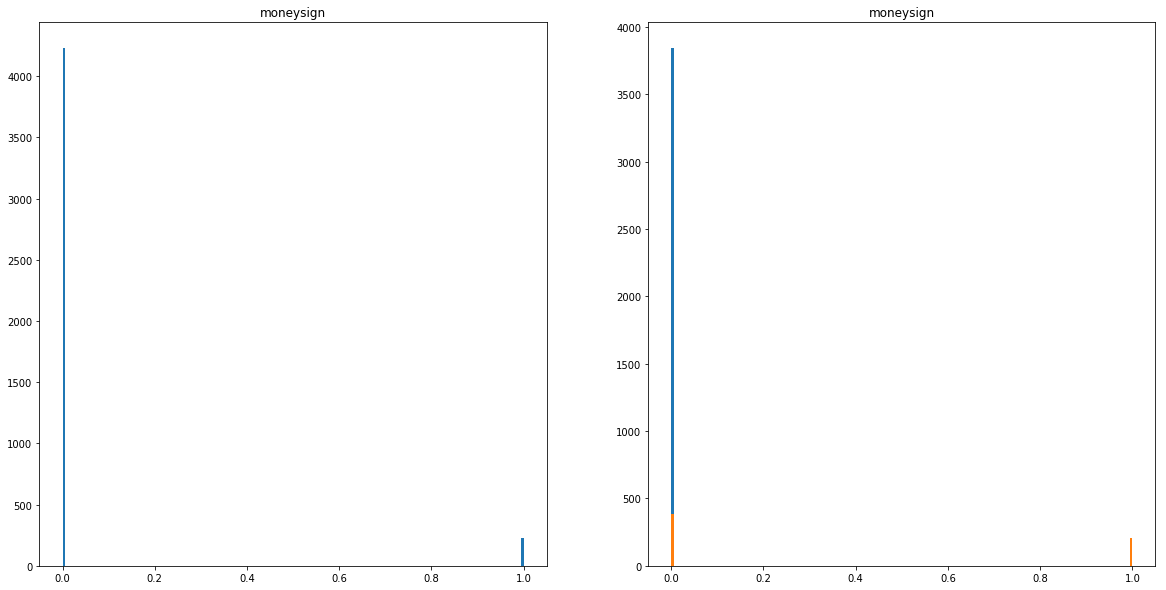

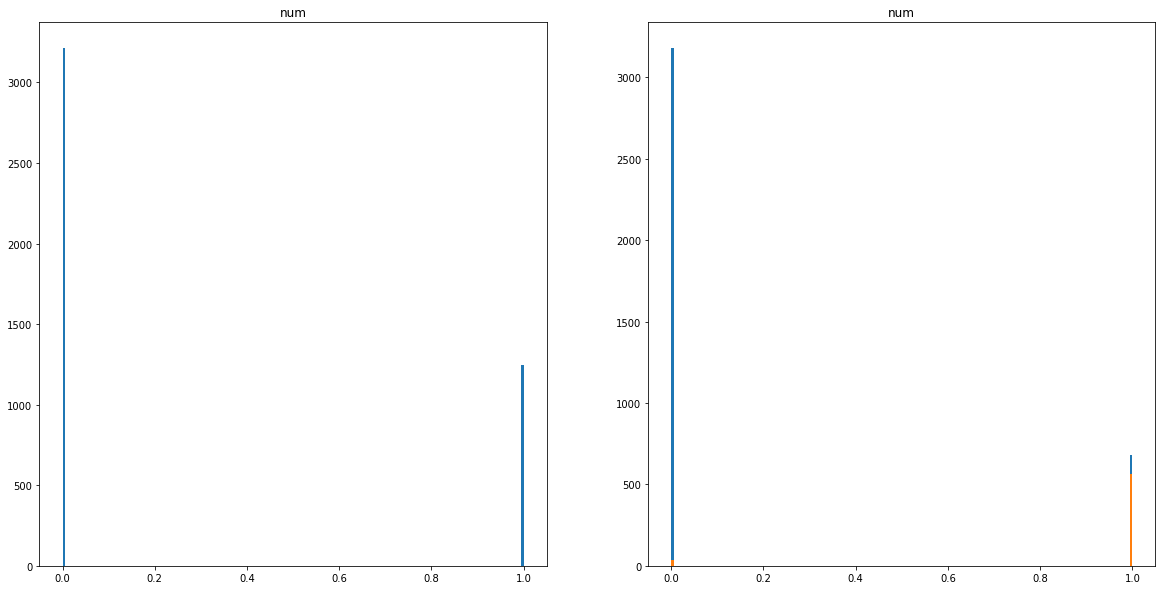

In [42]:
for col in X_train.columns[2 :] :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
#     ax.set_ylabel('% фрагментов', fontsize=12)
#     ax.set_xlabel('Имя автора', fontsize=12) 
    axes[0].set_title(col)
    axes[0].hist(X_train[col], bins = 200);
    axes[1].set_title(col)
    axes[1].hist(X_train[col][X_train['label'] == 0], bins = 200, label = 'ham')
    axes[1].hist(X_train[col][X_train['label'] == 1], bins = 200, label = 'spam')
    plt.show()

#### Судя по гистограммам признаов, почти все спам сообщения содержат символ валюты. Также половина спам сообщений содержит число в своем тексте и опечатку. При генерации этих признаков подобный эффект и ожидался.

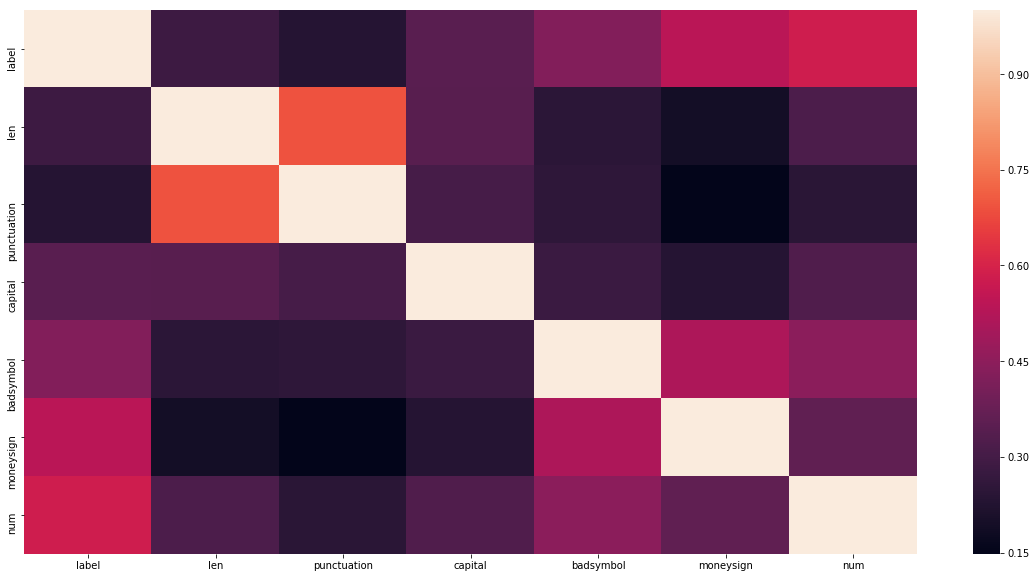

In [43]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(X_train[['label', 'len', 'punctuation', 'capital', 'badsymbol',
       'moneysign', 'num']].corr())

#### - Во-первых, длина SMS коррелирует с числом гласных/согласных, числом знаков препинания, тут ничего удивительного.
#### - Во-вторых, видим корреляцию между наличием символа, не являющегося цифрой или буквой алфавита, и наличием символов "$" и "£", так как второе является подмножество первого.
#### - В-третьих, видим корреляцию между целевой переменной и наличием числа в тексте SMS и наличием символа денежки.

### Выбор метрики

#### Решается задача классификации на два класса. Классы несбалансированы, FP - нормальное SMS помечено как спам, это недопустимо. FN - спам помечен как нормальное SMS, допустимо, но не сильно хочется. Поэтому в качестве метрики будем использовать rocauc.

### Выбор модели

#### На заре развития спам-фильтров их строили используя наивный байесовский классификатор, поэтому будем рассматривать эту модель. Также у нас ожидается много признаков после использования преобразования tfidf к тексту SMS, поэтому будем рассматривать логистическую регрессию. 

### Предобработка данных

#### Будем использовать преобразование tfidf для текста SMS, так же отмасштабируем признаки.

In [44]:
scaler = StandardScaler()

In [45]:
cols = ['len', 'punctuation', 'capital', 'badsymbol', 'moneysign', 'num']
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[cols]), columns = cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[cols]), columns = cols)

#### Данных у нас не так много, поэтому выбираем кросс-валидацию на 10 фолдов. Для начала посмотрим на наши модели из коробки, ничего не настраивая.

In [46]:
def valid(model, n, bayes = False) :
    skf = StratifiedKFold(n_splits = n, random_state = 17)
    auc_scores = []
    for train_index, valid_index in skf.split(X_train_scaled, y_train):
        X_train_part, X_valid = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
        y_train_part, y_valid = y_train[train_index], y_train[valid_index]
        
        X_train_sms, X_valid_sms = X_train.iloc[train_index]['sms'], X_train.iloc[valid_index]['sms']
        cv = TfidfVectorizer(ngram_range = (1, 3))
        X_train_bow = cv.fit_transform(X_train_sms)
        X_valid_bow = cv.transform(X_valid_sms)     
        if bayes :
            X_train_new = X_train_bow
            X_valid_new = X_valid_bow
        else :
            X_train_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_bow, X_train_part]))
            X_valid_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_valid_bow, X_valid]))
        model.fit(X_train_new, y_train_part)
        model_pred_for_auc = model.predict_proba(X_valid_new)
        auc_scores.append(roc_auc_score(y_valid, model_pred_for_auc[:, 1]))
    return np.mean(auc_scores)

In [47]:
logit = LogisticRegression(random_state = 17)
bayes = MultinomialNB()

In [48]:
scores_logit = valid(logit, 10)
print('Logistic regreession - rocauc : {}'.format(scores_logit))

Logistic regreession - rocauc : 0.982530066754182


In [49]:
scores_bayes = valid(bayes, 10, True)
print('Bayessian classfier - rocauc : {}'.format(scores_bayes))

Bayessian classfier - rocauc : 0.9643017375323953


#### Видим, что логистическая регрессия справляется получше. Дальше будем работать только с ней.

### Настройка гиперпараметров и построение кривых валидации и обучения.

In [50]:
def valid_for_valid_plots(model, n, bayes = False) :
    skf = StratifiedKFold(n_splits = n, random_state = 17)
    auc_scores_cv = []
    auc_scores_valid = []
    for train_index, valid_index in skf.split(X_train_scaled, y_train):
        X_train_part, X_valid = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
        y_train_part, y_valid = y_train[train_index], y_train[valid_index]
        
        X_train_sms, X_valid_sms = X_train.iloc[train_index]['sms'], X_train.iloc[valid_index]['sms']
        cv = TfidfVectorizer(ngram_range = (1, 3))
        X_train_bow = cv.fit_transform(X_train_sms)
        X_valid_bow = cv.transform(X_valid_sms)     
        if bayes :
            X_train_new = X_train_bow
            X_valid_new = X_valid_bow
        else :
            X_train_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_bow, X_train_part]))
            X_valid_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_valid_bow, X_valid]))
            
        model.fit(X_train_new, y_train_part)
        auc_scores_cv.append(roc_auc_score(y_train_part, model.predict_proba(X_train_new)[:, 1]))
        model_pred_for_auc = model.predict_proba(X_valid_new)
        auc_scores_valid.append(roc_auc_score(y_valid, model_pred_for_auc[:, 1]))
    return 1 - np.mean(auc_scores_valid), 1 - np.mean(auc_scores_cv)

#### Построим кривые валидации

In [51]:
Cs = [0.1 * i for i in range(1, 21)]

In [52]:
scores = []
for c in Cs :
    logit = LogisticRegression(C = c, random_state = 17)
    scores.append(valid_for_valid_plots(logit, 10))

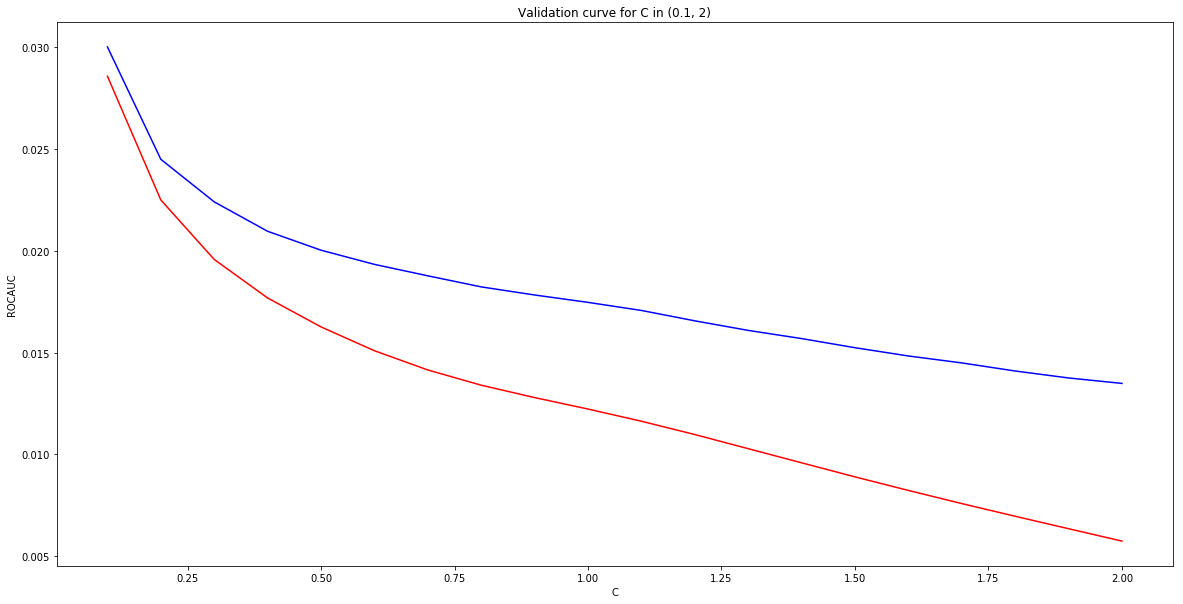

In [53]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
plt.plot(Cs, [i[0] for i in scores], color = 'blue', label='holdout')
plt.plot(Cs, [i[1] for i in scores], color = 'red', label='CV')
plt.ylabel("ROCAUC")
plt.xlabel("C")
plt.title('Validation curve for C in (0.1, 2)');


####  Будем перебирать значения C в интервале [0.5, 1.5]. При С < 0.5 происходит недообучение. При С > 1.5 ошибка на трейне упирается в ноль,  а на валидации не падает, это переобучение.

In [54]:
Cs = np.linspace(0.5, 1.5, 10)

In [55]:
for c in Cs :
    logit = LogisticRegression(C = c, random_state = 17)
    print(c, valid(logit, 10))

0.5 0.9799654823967637
0.6111111111111112 0.9806968605879642
0.7222222222222222 0.9813541549051342
0.8333333333333333 0.981873049011233
0.9444444444444444 0.9823616340042968
1.0555555555555556 0.9827503129755699
1.1666666666666665 0.9832345526169626
1.2777777777777777 0.9838126792267479
1.3888888888888888 0.9842793549794957
1.5 0.9847588995121267


### C_opt = 1.5

In [56]:
C_opt = 1.5

#### Построим кривые обучения

In [57]:
def valid_for_train_plots(model, n, alpha, bayes = False) :
    skf = StratifiedKFold(n_splits = n, random_state = 17)
    auc_scores_cv = []
    auc_scores_valid = []
    for train_index, valid_index in skf.split(X_train_scaled[: int(X_train_scaled.shape[0] * alpha)], y_train[: int(X_train_scaled.shape[0] * alpha)]):
        X_train_part, X_valid = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
        y_train_part, y_valid = y_train[train_index], y_train[valid_index]
        
        X_train_sms, X_valid_sms = X_train.iloc[train_index]['sms'], X_train.iloc[valid_index]['sms']
        cv = TfidfVectorizer(ngram_range = (1, 3))
        X_train_bow = cv.fit_transform(X_train_sms)
        X_valid_bow = cv.transform(X_valid_sms)     
        if bayes :
            X_train_new = X_train_bow
            X_valid_new = X_valid_bow
        else :
            X_train_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_bow, X_train_part]))
            X_valid_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_valid_bow, X_valid]))
            
        model.fit(X_train_new, y_train_part)
        auc_scores_cv.append(roc_auc_score(y_train_part, model.predict_proba(X_train_new)[:, 1]))
        model_pred_for_auc = model.predict_proba(X_valid_new)
        auc_scores_valid.append(roc_auc_score(y_valid, model_pred_for_auc[:, 1]))
    return np.mean(auc_scores_valid), np.mean(auc_scores_cv)

In [58]:
alphas = [0.1 * i for i in range(1, 11)]
scores = []
for alpha in  alphas :
    logit = LogisticRegression(C = C_opt, random_state = 17)
    scores.append(valid_for_train_plots(logit, 10, alpha = alpha))

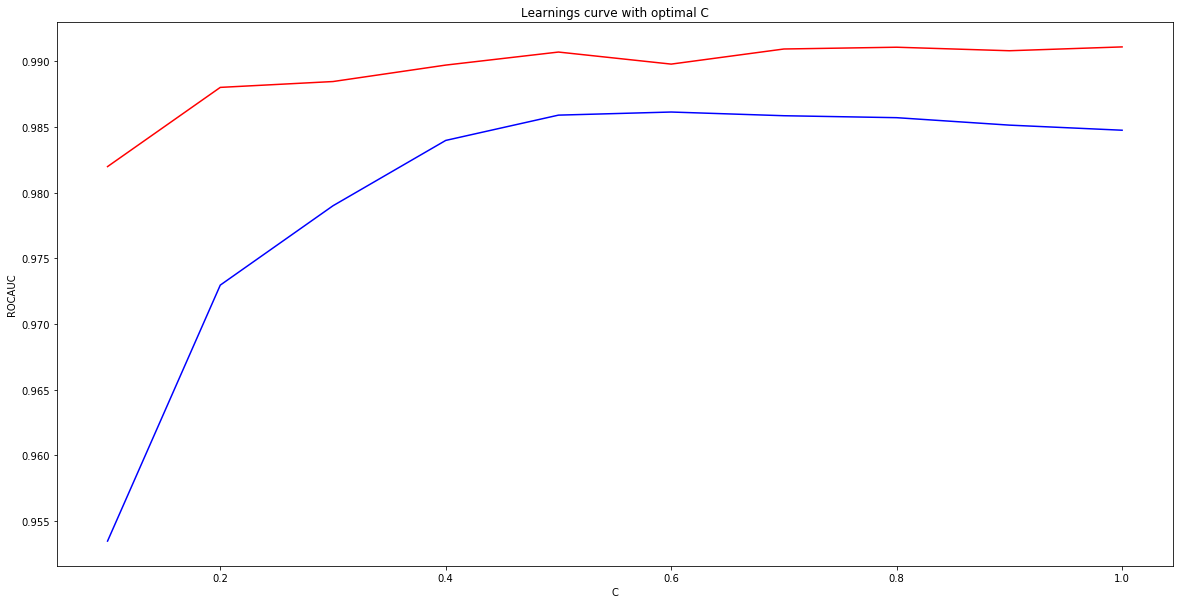

In [59]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
plt.plot(alphas, [i[0] for i in scores], color = 'blue', label='holdout')
plt.plot(alphas, [i[1] for i in scores], color = 'red', label='CV')
plt.ylabel("ROCAUC")
plt.xlabel("C")
plt.title('Learnings curve with optimal C');

#### Судя по кривым обучения, происходит недообучение и для улучшения результата надо усложнить модель.

### Прогноз для тестовой выборки

In [60]:
cv = TfidfVectorizer(ngram_range = (1, 3))
X_train_sms = cv.fit_transform(X_train['sms'])
X_test_sms = cv.transform(X_test['sms'])

In [61]:
train = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_sms, X_train_scaled]))
test = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_test_sms, X_test_scaled]))

In [62]:
logit = LogisticRegression(C = C_opt, random_state = 17)

In [63]:
logit.fit(train, y_train)

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
for x, y in zip(cols, logit.coef_[0][len(cv.get_feature_names()) :]) :
    print(x, y)

len 0.20879137888900498
punctuation 0.07800660249514209
capital 0.16970614575957085
badsymbol 0.07753813384848861
moneysign 0.6236278717691773
num 1.4086045112975176


#### Видим, что для нашей модели признаки наличия числа и наличие символа валюты в тексте SMS являются важными, также число слов в тексте и число заглавных букв, а вот признаки наличия опечаток и знаков препинания не так уж и важны.

In [65]:
logit_pred = logit.predict_proba(test)

In [66]:
roc_auc_score(y_test, logit_pred[:, 1])

0.9889046368474439

#### Качество на тесте соответствует ожиданиям после кросс-валидации

### Выводы

#### Предложено решение задачи фильтрации спама на основе модели логистической регрессии. Можно использовать подобные спам-фильтры для SMS, электронной почты.

#### Дальнейшее развитие модели может быть связано с лемматизацией/стеммингом текстов SMS. Использовать стекинг/блендинг нескольких моделей.